# Homework 5
### ASTR-324, Spring 2017, Ivezic & Juric, University of Washington
https://github.com/uw-astr-324-s17/astr-324-s17


## Problem

The flux vs. time plot below shows UV flux measurements for an active M dwarf
star. These stars are known for their exponential bursts of energy, well described
by the profile 
$$\rm{flux(time)} = A\,exp(-\alpha \, t)$$ 
for $t>T$ (recall Week-5-Thu lecture). 
Find how many bursts were observed for this star during the provided 2 hour 
stretch of data and estimate their amplitudes (A), decay constants ($\alpha$),
and the time of bursts. 

**Hints:**
- there are no more than 2 bursts in this dataset
- you can use flat priors for A and T and the background (non-bursting) flux level,
  and Jeffreys' prior for $\alpha$
- you can do approximate model comparison based on the BIC 
- you can relatively easily solve this problem by generalizing the code from [fig. 10.25](http://www.astroml.org/book_figures/chapter10/fig_matchedfilt_burst.html)

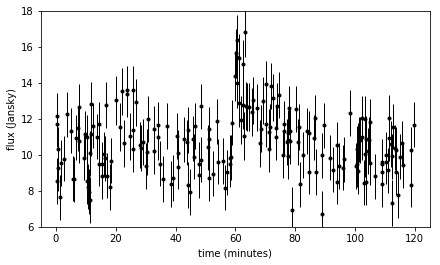

In [52]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

# read data
data = np.loadtxt('HW5dataFinal.txt', unpack=True)
t, y_obs, sigma_y = data

# plot data
fig = plt.figure(figsize=(12, 12))
ax = fig.add_axes([0.5, 0.7, 0.45, 0.25])
ax.errorbar(t, y_obs, sigma_y, fmt='.', lw=1, c='k')
ax.set_xlim(-5, 125)
ax.set_ylim(6.0, 18.001)
ax.set_xlabel('time (minutes)')
ax.set_ylabel(r'flux (Jansky)')

plt.show()

## Solution

 [-----------------100%-----------------] 50000 of 50000 complete in 19.5 sec 
chi2 =  211.704120237
chi2dof =  1.09691254009
BIC =  248.792341803
   TRUE      BEST-FIT
b0:  10 9.97207245931
A1:  4 4.31610683482
T1:  20 18.2861609107
alpha1:  0.15 0.136808290957
A2:  5 4.82529764507
T2:  60 60.0212551094
alpha2:  0.1 0.0923191977714


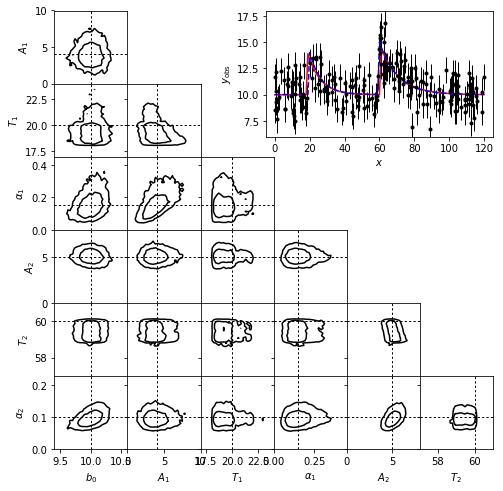

In [55]:
import numpy as np
from matplotlib import pyplot as plt
from astroML.decorators import pickle_results
from astroML.plotting.mcmc import plot_mcmc

# Hack to fix import issue in older versions of pymc
import scipy
import scipy.misc
scipy.derivative = scipy.misc.derivative
import pymc


#----------------------------------------------------------------------
### Set up data sample

# model for y(x) 
def burst(x, b0, A1, T1, alpha1, A2, T2, alpha2):
    """Burst model"""
    y = np.empty(x.shape)
    # the background level 
    y.fill(b0)
    # add bursts if needed 
    mask = (x >= T1)
    y[mask] += A1 * np.exp(-alpha1 * (x[mask] - T1))
    mask = (x >= T2)
    y[mask] += A2 * np.exp(-alpha2 * (x[mask] - T2))
    return y


# input model parameters 
Ndata = 200
b0_true = 10
A1_true = 4
T1_true = 20
alpha1_true = 0.15
A2_true = 5
T2_true = 60
alpha2_true = 0.1

labels = ['$b_0$', '$A_1$', '$T_1$', r'$\alpha_1$', '$A_2$', '$T_2$', r'$\alpha_2$']
limits = [(9.4, 10.6), (0, 9.99), (16.99, 23.99), (0.0, 0.45), (0, 8.0), (57, 61), (0.0, 0.23)]
true = [b0_true, A1_true, T1_true, alpha1_true, A2_true, T2_true, alpha2_true]


if (0):
    ## grid of values for independent variable 
    t = 120 * np.random.random(Ndata)
    t = np.sort(t) 
    y_true = burst(t, b0_true, A1_true, T1_true, alpha1_true, A2_true, T2_true, alpha2_true)

    # "measurement" uncertainty
    sigmaBase = 0.8
    sigma_y = sigmaBase + 0.5*np.sqrt(y_true/10) + np.random.normal(0.0,0.1)
    # add random noise 
    y_obs = np.random.normal(y_true, sigma_y)
  
    # package data 
    data = t, y_obs, sigma_y 
    np.savetxt('HW5data.txt', np.c_[t, y_obs, sigma_y])
else:
    data = np.loadtxt('HW5dataFinal.txt', unpack=True)
    t, y_obs, sigma_y = data

#----------------------------------------------------------------------

#----------------------------------------------------------------------
# Set up MCMC sampling with PyMC 
b0 = pymc.Uniform('b0', 0, 50, value=50 * np.random.random())
A1 = pymc.Uniform('A1', 0, 50, value=10 * np.random.random())
T1 = pymc.Uniform('T1', 0, 120, value=30 * np.random.random())
log_alpha1 = pymc.Uniform('log_alpha1', -3, 2, value=-0.1)
A2 = pymc.Uniform('A2', 0, 50, value=10 * np.random.random())
T2 = pymc.Uniform('T2', 0, 120, value=60 * np.random.random())
log_alpha2 = pymc.Uniform('log_alpha2', -3, 2, value=-0.1)
# for single burst model: forces A2 to stay 0 (not efficient but simple) 
#A2 = pymc.Uniform('A2', 0, 0.001, value=0 * np.random.random())


# uniform prior on log(alpha)
@pymc.deterministic
def alpha1(log_alpha1=log_alpha1):
    return np.exp(log_alpha1)

@pymc.deterministic
def alpha2(log_alpha2=log_alpha2):
    return np.exp(log_alpha2)

@pymc.deterministic
def y_model(t=t, b0=b0, A1=A1, T1=T1, alpha1=alpha1, A2=A2, T2=T2, alpha2=alpha2):
    return burst(t, b0, A1, T1, alpha1, A2, T2, alpha2)

# specify likelihood function: gaussian with known sigma 
y = pymc.Normal('y', mu=y_model, tau=sigma_y ** -2, observed=True, value=y_obs)

model = dict(b0=b0, A1=A1, T1=T1, log_alpha1=log_alpha1, alpha1=alpha1, 
             A2=A2, T2=T2, log_alpha2=log_alpha2, alpha2=alpha2, y_model=y_model, y=y)

# Run the MCMC sampling
#@pickle_results('HW5_burst.pkl')
def compute_MCMC_results(niter=50000, burn=10000):
    S = pymc.MCMC(model)
    S.sample(iter=niter, burn=burn)
    traces = [S.trace(s)[:] for s in ['b0', 'A1', 'T1', 'alpha1', 'A2', 'T2', 'alpha2']]

    M = pymc.MAP(model)
    M.fit()
    fit_vals = (M.b0.value, M.A1.value, M.T1.value, M.alpha1.value, M.A2.value, M.T2.value, M.alpha2.value)

    # force burst #1 to be the one with smaller T 
    if (M.T1.value > M.T2.value):
        traces = [S.trace(s)[:] for s in ['b0', 'A2', 'T2', 'alpha2', 'A1', 'T1', 'alpha1']]
        fit_vals = (M.b0.value, M.A2.value, M.T2.value, M.alpha2.value, M.A1.value, M.T1.value, M.alpha1.value)

    return traces, fit_vals

#----------------------------------------------------------------------

traces, fit_vals = compute_MCMC_results()

### compute chi2
kmodel = 7
#kmodel = 4
y_fit = burst(t, *fit_vals)
chi2 = np.sum(((y_obs-y_fit)/sigma_y)**2)

print ' '
print 'chi2 = ', chi2
print 'chi2dof = ', chi2/(Ndata-kmodel)
print 'BIC = ', (chi2 + kmodel*np.log(Ndata))

print "   TRUE      BEST-FIT" 
print 'b0: ', b0_true, fit_vals[0] 
print 'A1: ', A1_true, fit_vals[1] 
print 'T1: ', T1_true, fit_vals[2] 
print 'alpha1: ', alpha1_true, fit_vals[3] 
print 'A2: ', A2_true, fit_vals[4] 
print 'T2: ', T2_true, fit_vals[5] 
print 'alpha2: ', alpha2_true, fit_vals[6] 


#------------------------------------------------------------
# Plot the results

fig = plt.figure(figsize=(7, 7))
fig.subplots_adjust(bottom=0.1, top=0.95,
                    left=0.1, right=0.95,
                    hspace=0.05, wspace=0.05)

# This function plots multiple panels with the traces
plot_mcmc(traces, labels=labels, limits=limits, true_values=true, fig=fig, bins=30, colors='k')

# Plot the model fit
ax = fig.add_axes([0.5, 0.7, 0.45, 0.25])
t_fit = np.linspace(0, 120, 121)
y_true = burst(t_fit, b0_true, A1_true, T1_true, alpha1_true, A2_true, T2_true, alpha2_true)
y_fit = burst(t_fit, *fit_vals)

ax.errorbar(t, y_obs, sigma_y, fmt='.', lw=1, c='k')
ax.plot(t_fit, y_fit, '-k', c='red')
ax.plot(t_fit, y_true, '--', c='blue')
ax.set_xlim(-5, 125)
ax.set_ylim(6.0, 18.001)
ax.set_xlabel('$x$')
ax.set_ylabel(r'$y_{\rm obs}$')

plt.show()


## double burst 
# chi2 =  211.723373711
# chi2dof =  1.09701229902
# BIC =  248.811595277
#    TRUE      BEST-FIT
# b0:  10 9.97636723924
# A1:  4 3.64951738972
# T1:  20 19.3434818817
# alpha1:  0.15 0.132454131535
# A2:  5 4.84590342566
# T2:  60 60.0136424059
# alpha2:  0.1 0.0926030428346  
#
## single burst case can be run after
# 1) prior for A2 is uncommented
# 2) kmodel is changed from 7 to 4
## single burst 
# chi2 =  240.528373458
# chi2dof =  1.22718557887
# BIC =  261.721642925
#    TRUE      BEST-FIT
# b0:  10 10.2175189713
# A1:  4 5.22686889962
# T1:  20 59.0835228344
# alpha1:  0.15 0.109010655093
# A2:  5 0.00099999993034
# T2:  60 73.9854663772
# alpha2:  0.1 0.496799933756